In [22]:
import numpy as np
import h5py 
import time 
import matplotlib.pyplot as plt
import scipy
from dnn_utils_v2 import *
from scipy import ndimage
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [23]:
#build an image classifier:
train_x_orig , train_y , test_x_orig , test_y , classes = load_data()

0


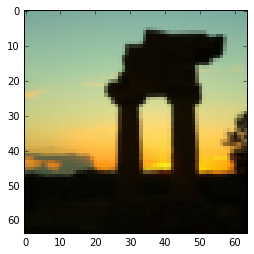

In [24]:
plt.imshow(train_x_orig[40])
print str(train_y[0,40])

In [25]:
#explore dataset
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

In [26]:
#reshape training data and testing data
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0],-1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0],-1).T
#standardise pixel values 
train_x = train_x_flatten/255
test_x = test_x_flatten/255


In [27]:
def intialize_parameters(n_x,n_h,n_y):
    np.random.seed(1)
    w1 = np.random.rand(n_h,n_x) * 0.01
    b1 = np.zeros(n_h,1)
    w2 = np.random.rand(n_y,n_h) * 0.01
    b2 = np.zeros(n_y,1)
    
        
    assert(w1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(w2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"w1": w1,
                  "b1": b1,
                  "w2": w2,
                  "b2": b2}
    
    return parameters
    

In [28]:
def intialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    for l in range(1,L):
        parameters['w' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
        assert(parameters['w' + str(l)].shape == (layer_dims[l],layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l],1))
        
    return parameters

In [29]:
def linear_forward(A, W, b):
    ### START CODE HERE ### (≈ 1 line of code)
    Z = np.dot(W, A) + b
    ### END CODE HERE ###
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [30]:
def linear_activation_forward(A_prev , w , b ,activation):
    if activation == "sigmoid":
        z , linear_cache = linear_forward(A_prev,w,b)
        A , activation_cache = sigmoid(z)
    elif activation == "relu":
        z , linear_cache = linear_forward(A_prev, w, b)
        A , activation_cache = relu(z)
        ### END CODE HERE ###
    assert (A.shape == (w.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [31]:

def L_model_forward(X,parameters):
    caches = []
    A=X
    L = len(parameters)//2
    for l in range(1,L):
        A_prev = A
        A,cache = linear_activation_forward(A_prev,parameters["w" + str(l)] , parameters["b"+str(l)],activation ="relu")
        caches.append(cache)
    AL , cache = linear_activation_forward(A,parameters["w2"],parameters["b2"],activation = "sigmoid")
    caches.append(cache)
    assert(AL.shape == (1,X.shape[1]))        
    return AL, caches

In [32]:
def compute_cost(AL,Y):
    m = Y.shape[1]
    cost = -(1/m)*np.sum(np.dot(Y,np.log(AL).T) + np.dot((1-Y),np.log(1-AL).T))
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    return cost

In [33]:
def linear_backward(dz,cache):
    A_prev , w,b = cache
    m = A_prev.shape[1]
    dw = (1/m)*np.dot(dz,A_prev.T)
    db = np.sum(dz,axis=1,keepdims = True)/m
    da_prev = np.dot(w.T,dz)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dw.shape == w.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dw, db

In [34]:
def L_model_backward(AL,Y,caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y= Y.reshape(AL.shape)
    
    dal = -(np.divide(Y,AL) - np.divide(1-Y,1-AL))
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dw" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    ### END CODE HERE ###
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dw_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dw" + str(l + 1)] = dw_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [35]:
def update_parameters(parameters,grads,learning_rate):
    L = len(parameters) // 2
    for l in range(1,L):
        parameters["w" +  str(l+1)] = parameters["w"+str(l+1)] - learning_rate*grads["dw" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db"+str(l+1)]
    return paramters


In [36]:
layer_dims = [12288,20,7,5,1] #5 layer model
def L_layer_model(X,Y,layer_dims , learning_rate = 0.0075 , num_iterations = 3000,print_cost = False):
    np.random.seed(1)
    costs = []
    parameters = intialize_parameters_deep(layer_dims)
    for i in range(0,num_iterations):
        AL , caches = L_model_forward(X,parameters)
        cost = compute_cost(AL,Y)
        grads = L_model_backward(AL,Y,caches)
        parameters = update_parameters(parameters,grads,learning_rate)
        if print_cost and i%100 ==0:
            print "cost after iteration %i: %f"%(i,cost)
        if print_cost and i % 100 ==0:
            costs.append(cost)
    plt.plot(np.squeeze(costs))
    plt.xlabel('iterations per tens')
    plt.ylabel('cost')
    plt.title("learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters


In [37]:
layers_dims = [12288, 20, 7, 5, 1]

In [38]:

parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

ValueError: shapes (7,20) and (5,209) not aligned: 20 (dim 1) != 5 (dim 0)